_Epsilon Discovery for Multi-Objective optimization_

This section explores the application of ε-NSGA-II, a variant of the NSGA-II evolutionary algorithm tailored for solving many-objective problems, in the context of optimizing flood risk mitigation strategies for the IJssel river. The objective is to support Rijkswaterstaat in identifying trade-offs between competing policy goals, such as reducing fatalities and economic damage while minimizing costs.

The optimization is conducted under deep uncertainty using a reference scenario approach. A total of 9 representative future scenarios are extracted, each evaluated three times to ensure robustness against randomness. Each run tests a different epsilon vector, which determines the granularity of convergence across the five outcome dimensions:

- Expected Annual Damage

- Dike Investment Costs

- Room for the River (RfR) Investment Costs

- Evacuation Costs

- Expected Number of Deaths

We compare three ε-configurations:

- Coarse: [1000000, 1000000, 1000000, 1000000, 10]

- Medium: [10000, 10000, 10000, 10000, 1]

- Fine: [1000, 1000, 1000, 1000, 0.1]

Each configuration runs 10,000 function evaluations per scenario, resulting in over 80,000 evaluations per epsilon setting. The outputs are visualized using parallel coordinate plots to evaluate the diversity and spread of solutions across objectives.

In [10]:
import os
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import (
    Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator,
    ema_logging, Constant, Scenario, HypervolumeMetric,
    GenerationalDistanceMetric, EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric, SpacingMetric, Constraint)

from ema_workbench.em_framework.optimization import (
    EpsilonProgress, ArchiveLogger)

from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import parcoords

In [17]:
def execute_search(eps_vals, eval_count, scen_list):
    output_data = []
    progress_data = []

    archive_path = "./archives_epsilon"
    os.makedirs(archive_path, exist_ok=True)

    with MultiprocessingEvaluator(sim_model) as runner:
        for s in scen_list:
            for rep in range(3):
                temp_path = os.path.join(archive_path, "tmp")
                if os.path.exists(temp_path):
                    shutil.rmtree(temp_path)

                metrics = [
                    ArchiveLogger(
                        archive_path,
                        [x.name for x in sim_model.levers],
                        [y.name for y in sim_model.outcomes],
                        base_filename="optimization.tar.gz",
                    ),
                    EpsilonProgress()
                ]

                res, prog = runner.optimize(
                    nfe=eval_count,
                    searchover="levers",
                    epsilons=eps_vals,
                    constraints=None,
                    convergence=metrics,
                    reference=s,
                )

                res_path = archive_path
                os.makedirs(res_path, exist_ok=True)

                res.to_csv(os.path.join(res_path, f"output__scen{s.name}__run{rep}.csv"))
                pd.DataFrame(prog).to_csv(os.path.join(res_path, f"log__scen{s.name}__run{rep}.csv"))

                output_data.append(res)
                progress_data.append(prog)

    return output_data, progress_data



In [18]:
def read_optimization_data(folder):
    collected = []
    for file in os.listdir(folder):
        if file.startswith('output__') and file.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder, file))
            collected.append(df)
    return pd.concat(collected)


[MainProcess/INFO] pool started with 24 workers
100%|████████████████████████████████████| 10000/10000 [03:47<00:00, 43.90it/s]
[MainProcess/INFO] optimization completed, found 152 solutions
100%|████████████████████████████████████| 10000/10000 [03:59<00:00, 41.75it/s]
[MainProcess/INFO] optimization completed, found 145 solutions
100%|████████████████████████████████████| 10000/10000 [03:48<00:00, 43.79it/s]
[MainProcess/INFO] optimization completed, found 140 solutions
100%|████████████████████████████████████| 10000/10000 [04:02<00:00, 41.27it/s]
[MainProcess/INFO] optimization completed, found 167 solutions
100%|████████████████████████████████████| 10000/10000 [04:05<00:00, 40.79it/s]
[MainProcess/INFO] optimization completed, found 149 solutions
100%|████████████████████████████████████| 10000/10000 [04:06<00:00, 40.53it/s]
[MainProcess/INFO] optimization completed, found 173 solutions
100%|████████████████████████████████████| 10000/10000 [03:56<00:00, 42.33it/s]
[MainProcess/I

Total solutions for ε=[1000000, 1000000, 1000000, 1000000, 10]: 1006


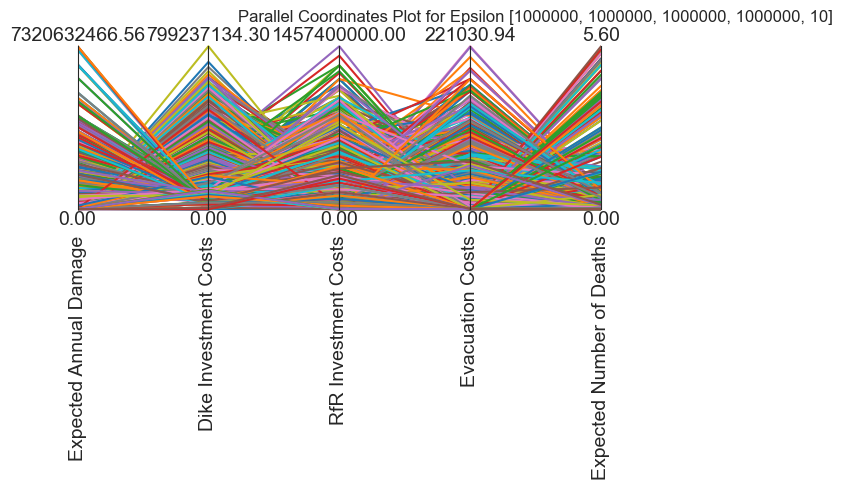

[MainProcess/INFO] pool started with 24 workers
100%|████████████████████████████████████| 10000/10000 [03:55<00:00, 42.39it/s]
[MainProcess/INFO] optimization completed, found 209 solutions
100%|████████████████████████████████████| 10000/10000 [03:51<00:00, 43.18it/s]
[MainProcess/INFO] optimization completed, found 253 solutions
100%|████████████████████████████████████| 10000/10000 [03:50<00:00, 43.34it/s]
[MainProcess/INFO] optimization completed, found 238 solutions
100%|████████████████████████████████████| 10000/10000 [03:55<00:00, 42.51it/s]
[MainProcess/INFO] optimization completed, found 362 solutions
100%|████████████████████████████████████| 10000/10000 [03:50<00:00, 43.46it/s]
[MainProcess/INFO] optimization completed, found 312 solutions
100%|████████████████████████████████████| 10000/10000 [03:56<00:00, 42.26it/s]
[MainProcess/INFO] optimization completed, found 294 solutions
100%|████████████████████████████████████| 10000/10000 [04:10<00:00, 39.96it/s]
[MainProcess/I

Total solutions for ε=[10000, 10000, 10000, 10000, 1]: 1778


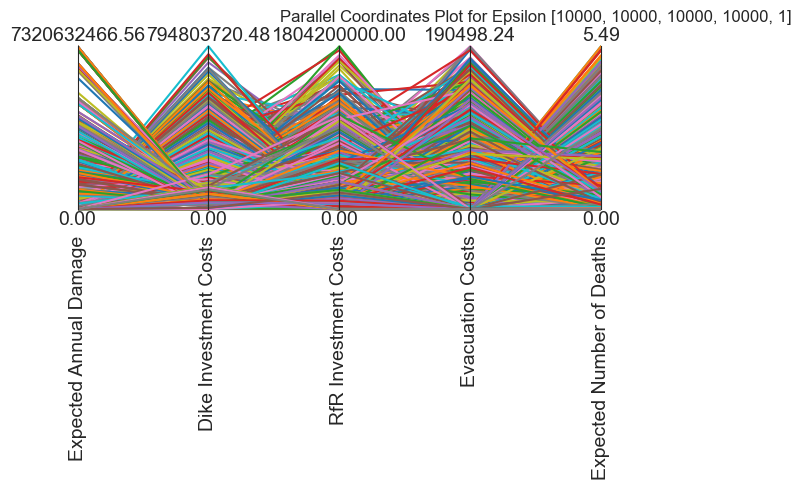

[MainProcess/INFO] pool started with 24 workers
100%|████████████████████████████████████| 10000/10000 [03:55<00:00, 42.47it/s]
[MainProcess/INFO] optimization completed, found 309 solutions
100%|████████████████████████████████████| 10000/10000 [03:55<00:00, 42.52it/s]
[MainProcess/INFO] optimization completed, found 278 solutions
100%|████████████████████████████████████| 10000/10000 [03:51<00:00, 43.21it/s]
[MainProcess/INFO] optimization completed, found 278 solutions
100%|████████████████████████████████████| 10000/10000 [04:08<00:00, 40.20it/s]
[MainProcess/INFO] optimization completed, found 386 solutions
100%|████████████████████████████████████| 10000/10000 [04:00<00:00, 41.50it/s]
[MainProcess/INFO] optimization completed, found 520 solutions
100%|████████████████████████████████████| 10000/10000 [04:28<00:00, 37.22it/s]
[MainProcess/INFO] optimization completed, found 493 solutions
100%|████████████████████████████████████| 10000/10000 [04:10<00:00, 39.98it/s]
[MainProcess/I

Total solutions for ε=[1000, 1000, 1000, 1000, 0.1]: 2373


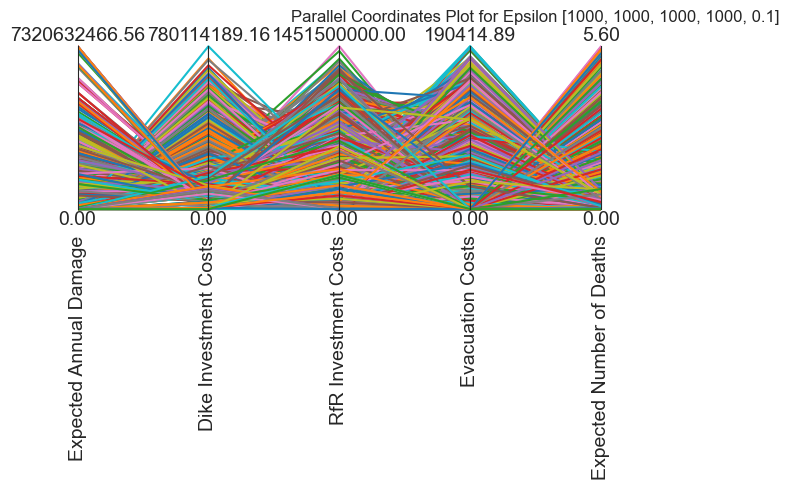

In [19]:

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    sim_model, _ = get_model_for_problem_formulation(2)

    scen_df = pd.read_csv("./data/Selected_Scenarios.csv")
    scenario_bank = []

    for idx in range(scen_df.shape[0]):
        scen_data = {}
        for col in scen_df.columns:
            if col == 'scenario':
                continue
            scen_data[col] = scen_df.loc[idx, col]
        generated = Scenario(scen_df.loc[idx, 'scenario'], **scen_data)
        scenario_bank.append(generated)

    eps_sets = [
        [1000000, 1000000, 1000000, 1000000,10],
        [10000, 10000, 10000,10000,1],
        [1000, 1000, 1000, 1000,0.1]
    ]
    evals = 10000

    for eps in eps_sets:
        outputs, logs = execute_search(eps, evals, scenario_bank)
        collected_data = read_optimization_data("./archives_epsilon")

        print(f"Total solutions for ε={eps}: {collected_data.shape[0]}")

        key_outputs = [
            'Expected Annual Damage',
            'Dike Investment Costs',
            'RfR Investment Costs',
            'Evacuation Costs',
            'Expected Number of Deaths'
        ]

        # Extract the outcomes from the results
        outcomes = collected_data[key_outputs]

        # Get the limits for the parallel coordinates plot
        limits = parcoords.get_limits(outcomes)
        # Create a ParallelAxes object with the limits
        axes = parcoords.ParallelAxes(limits)
        # Plot the outcomes on the parallel coordinates plot
        axes.plot(outcomes)

        # Set the title and save the plot as an image file
        plt.title(f'Parallel Coordinates Plot for Epsilon {eps}')
        plt.savefig(f'parallel_coordinates_eps_{eps}.png')
        plt.show()

Results: Choosing the epsilon setting

Three configurations of epsilon where ran. While the fine and medium configurations yielded more total solutions (2373 and 1778 respectively), they also incurred significantly higher computational demands and diminishing returns in terms of result diversity.

The coarse setting resulted in:

- 1006 solutions across all scenarios and seeds.

- A representative yet manageable Pareto front with meaningful variation across objectives.

- Significantly lower runtime compared to finer ε vectors (about 30% faster).

Given these trade-offs, the coarse ε-setting was selected as the final choice for further policy evaluation. This selection balances computational efficiency with solution quality, making it suitable for supporting timely decision-making within Rijkswaterstaat.